## Learning to Forecast Electricity Demand Using Long Short-Term Memory Approach

### Goal:
I aim to practice a more advanced machine learning algorithm to predict electricity demand and assess whether the advanced algorithm significantly increases accuracy and if it is worth the potentially longer computation time. As with previous projects, the goal is to forecast electricity demand. This time, I chose Long Short-Term Memory (LSTM), which is well-suited for data with long-term dependencies, like time series data.

### Basics about LSTM:
LSTM is an advanced version of Recurrent Neural Network (RNN), which possesses a kind of memory when processing data by looping outputs from the current state back to the next state. However, RNNs struggle with learning long-term dependencies, a problem that LSTM can overcome. LSTM uses memory cells or blocks, each containing gates to control the information flow, including input (for what is added), forget (for what is discarded), and output.

### Steps:

0. Set up the environment by installing the necessary packages and libraries.
1. Load hourly data, including electricity demand and weather. I used the same dataset as in the random forest case.
2. Visualize the electricity demand variations.
3. Drop NaN values in the data before modeling to avoid any errors.
4. Select features as in the random forest case and normalize the data, which is necessary for neural network approaches.
5. Divide the dataset into training and testing sets.
6. Build the LSTM model. In this case, I asked the model to consider information from up to a day ago. It took about two minutes to run the model 10 times.
7. Evaluate the model. The model achieved an accuracy of 98.59%.
8. Find the optimal epoch number. I ran the model with different epoch numbers and recorded their corresponding Mean Absolute Error. The learning curve plot shows that the MAE stabilizes after using 10 epochs. While it took over 20 minutes for making the plot, this approach can be used to find the optimal value for other hyperparameters as well.

In [3]:
### set up environment
!pip install tensorflow
import numpy as np  # array processing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.metrics import MeanAbsoluteError

In [2]:
### prepare data
# fix random seed for reproducibility
tf.random.set_seed(7)

# load data
# hourly energy demand data
energy_data_url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'
energy_data = pd.read_csv(energy_data_url)

# use Austria as an example
AT_energy_data = energy_data[['utc_timestamp', 'AT_load_actual_entsoe_transparency']]

# time format
AT_energy_data['utc'] = pd.to_datetime(AT_energy_data['utc_timestamp'])

# hourly weather data
weather_data_url = 'https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv'
weather_data = pd.read_csv(weather_data_url)  # replace with your file path
AT_weather_data = weather_data[['utc_timestamp', 'AT_temperature']]
AT_weather_data['utc'] = pd.to_datetime(AT_weather_data['utc_timestamp'])

# merge demand and weather data
AT_data = pd.merge(AT_energy_data, AT_weather_data, on='utc')
AT_data.head()

<ipython-input-2-292e10be5472>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_energy_data['utc'] = pd.to_datetime(AT_energy_data['utc_timestamp'])
<ipython-input-2-292e10be5472>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_weather_data['utc'] = pd.to_datetime(AT_weather_data['utc_timestamp'])


,utc_timestamp_x,AT_load_actual_entsoe_transparency,utc,utc_timestamp_y,AT_temperature
0,2014-12-31T23:00:00Z,NaN,2014-12-31 23:00:00+00:00,2014-12-31T23:00:00Z,-6.495
1,2015-01-01T00:00:00Z,5946.0,2015-01-01 00:00:00+00:00,2015-01-01T00:00:00Z,-6.503
2,2015-01-01T01:00:00Z,5726.0,2015-01-01 01:00:00+00:00,2015-01-01T01:00:00Z,-6.458
3,2015-01-01T02:00:00Z,5347.0,2015-01-01 02:00:00+00:00,2015-01-01T02:00:00Z,-6.253
4,2015-01-01T03:00:00Z,5249.0,2015-01-01 03:00:00+00:00,2015-01-01T03:00:00Z,-5.908


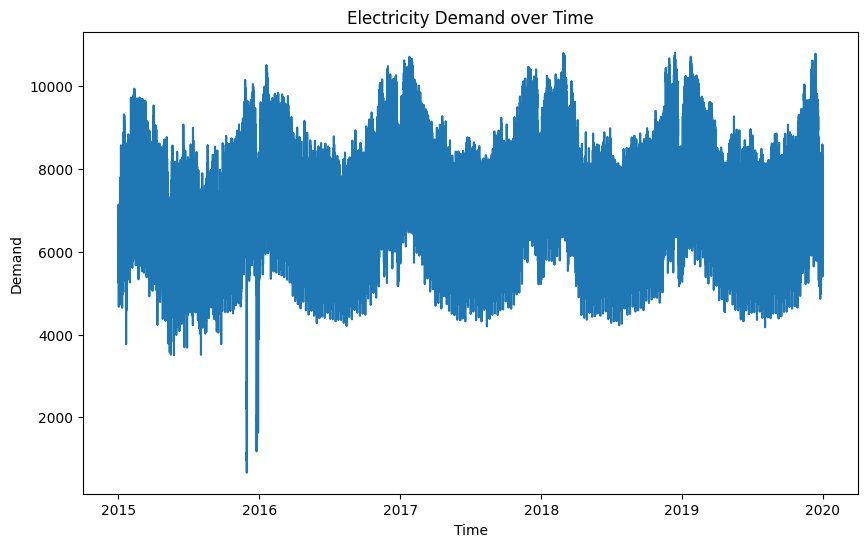

(43825, 9)


In [4]:
# Feature engineering
AT_data['Hour'] = AT_data['utc'].dt.hour
AT_data['DayOfWeek'] = AT_data['utc'].dt.dayofweek
AT_data['DayOfMonth'] = AT_data['utc'].dt.day
AT_data['Month'] = AT_data['utc'].dt.month

# Plotting the demand data
plt.figure(figsize=(10, 6))
plt.plot(AT_data['utc'], AT_data['AT_load_actual_entsoe_transparency'])
plt.title('Electricity Demand over Time')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

print(AT_data.shape)

In [5]:
# drop NaN before modeling
print(AT_data.isnull().sum())
print(AT_data.shape)
AT_data = AT_data.dropna()
print(AT_data.shape)

utc_timestamp_x                       0
AT_load_actual_entsoe_transparency    1
utc                                   0
utc_timestamp_y                       0
AT_temperature                        0
Hour                                  0
DayOfWeek                             0
DayOfMonth                            0
Month                                 0
dtype: int64
(43825, 9)
(43824, 9)


In [6]:
# Select features
# features = ['demand', 'temperature', 'hour', 'day_of_week', 'day_of_month', 'month']

features = ['AT_load_actual_entsoe_transparency', 'Hour', 'DayOfWeek', 'DayOfMonth', 'Month', 'AT_temperature']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(AT_data[features])
print(scaled_data[:5])

[[0.52095867 0.         0.5        0.         0.         0.22085731]
 [0.49926028 0.04347826 0.5        0.         0.         0.22175324]
 [0.46187987 0.08695652 0.5        0.         0.         0.22583471]
 [0.45221422 0.13043478 0.5        0.         0.         0.23270353]
 [0.45813197 0.17391304 0.5        0.         0.         0.24050809]]


In [7]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length, 0]  # The demand is the first feature
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Number of past time steps to consider for prediction
sequence_length = 24  # consider information back to 24 hours ago
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
print(X.shape)

(43800, 24, 6)


In [8]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X_train.shape)

(35040, 24, 6)


In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
# batch: # of samples before updating the model, often power of 2, larger #, slower but less noise, >=1 & <= samples in the training dataset
# epochs: # of iteration through the training dataset, btw 1 and infinity
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            11400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
876/876 [==============================] - 18s 17ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 2/10
876/876 [==============================] - 13s 15ms/step - loss: 0.0013 - val_loss: 7.4228e-04
Epoch 3/10
876/876 [==============================] - 13s 15ms/step - loss

274/274 [==============================] - 2s 5ms/step


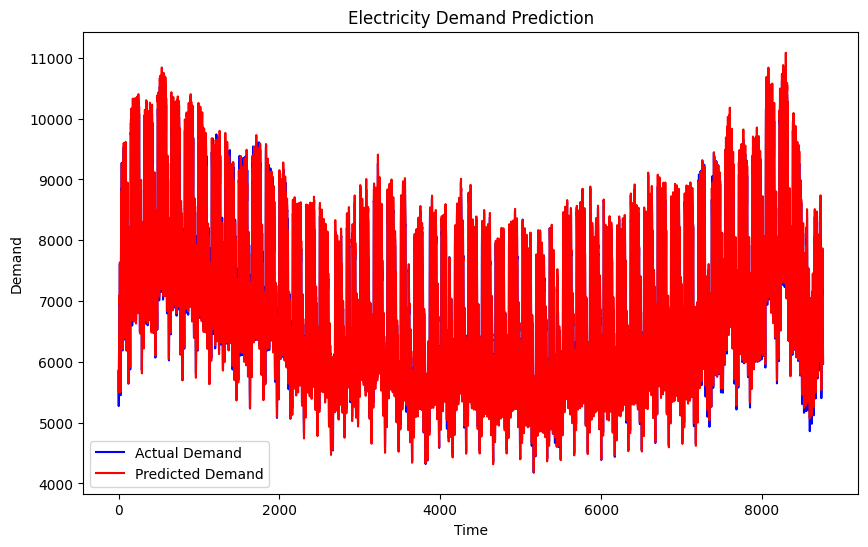

In [10]:
# Make predictions for the last 0.2 x data
predicted_demand = model.predict(X_test)
predicted_demand = scaler.inverse_transform(np.concatenate((predicted_demand, X_test[:, -1, 1:]), axis=1))[:, 0]  # Inverse transform and extract the demand
actual_demand = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actual_demand, color='blue', label='Actual Demand')
plt.plot(predicted_demand, color='red', label='Predicted Demand')
plt.title('Electricity Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [11]:
# Evaluate the model
mse = mean_squared_error(actual_demand, predicted_demand)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(actual_demand, predicted_demand)
print(f"Mean Absolute Error: {mae}")
accuracy_percent = (1 - (mae/actual_demand.mean()))*100
print(f'Accuracy:{accuracy_percent:.2f}%')

Mean Squared Error: 16676.520170522006
Mean Absolute Error: 101.69749245010517
Accuracy:98.59%


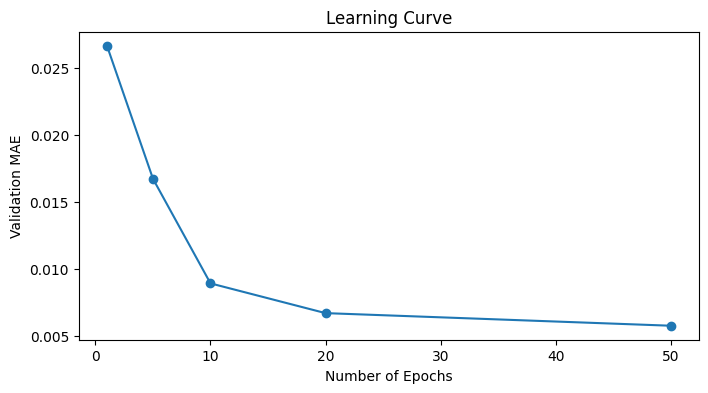

In [12]:
# Function to create and train the LSTM model
def create_and_train_model(epochs):
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(features))))
  model.add(LSTM(units=50))
  model.add(Dense(units=1))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])
  history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
  return history

# List of epoch numbers to try
epoch_numbers = [1, 5, 10, 20, 50]

# Store accuracies for each epoch number
accuracies = []

for epochs in epoch_numbers:
    history = create_and_train_model(epochs)
    val_mae = history.history['val_mean_absolute_error'][-1]
    accuracies.append(val_mae)

# Plot learning curve
plt.figure(figsize=(8,4))
plt.plot(epoch_numbers, accuracies, marker='o')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation MAE')
plt.title('Learning Curve')
plt.show()


### Summary:
It took slightly longer to run the model with 10 epochs, but the accuracy increased by about 1% compared to the random forest model.

### Other Applications:
Beyond this case, LSTM can be applied to stock price prediction, speech recognition, and text generation.

### Reference:
Differences between batch and epoch numbers: [Machine Learning Mastery](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)